## Importing necessary libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from tqdm import tqdm
import os

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Loading already prepared corpus

In [2]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Fine_Food_Review/corpus.csv")
print(df.head())

                                                Text       Time  Score
0  witti littl book make son laugh loud recit car...  939340800      1
1  grew read sendak book watch realli rosi movi i...  940809600      1
2  fun way children learn month year learn poem t...  944092800      1
3  great littl book read aloud nice rhythm well g...  944438400      1
4  book poetri month year goe month cute littl po...  946857600      1


### Since the dataset is very large so taking out 100K points to work on.

In [4]:
df1k = df.loc[:19999,:]
print("Shape:- ",df1k.shape)
print(df1k.head())
df1k['Score'].value_counts()

Shape:-  (20000, 3)
                                                Text       Time  Score
0  witti littl book make son laugh loud recit car...  939340800      1
1  grew read sendak book watch realli rosi movi i...  940809600      1
2  fun way children learn month year learn poem t...  944092800      1
3  great littl book read aloud nice rhythm well g...  944438400      1
4  book poetri month year goe month cute littl po...  946857600      1


1    17826
0     2174
Name: Score, dtype: int64

## Function for time based splitting into train and test data

In [0]:
from sklearn.model_selection import TimeSeriesSplit
def timesplit(x,y):
    ts = TimeSeriesSplit(n_splits = 4)
    for train_index,test_index in ts.split(x):
        x_train,x_test = x[train_index],x[test_index]
        y_train,y_test = y[train_index],y[test_index]
    return x_train,y_train,x_test,y_test

x_train,y_train,x_test,y_test = timesplit(df1k["Text"].values,df1k["Score"].values)

In [6]:
df1k = df.loc[:99999,:]
print("Shape:- ",df1k.shape)
#print(df1k.head())
print(df1k['Score'].value_counts())
x_train_1L,y_train_1L,x_test_1L,y_test_1L = timesplit(df1k["Text"].values,df1k["Score"].values)

Shape:-  (100000, 3)
1    87729
0    12271
Name: Score, dtype: int64


### Function for feature importance

In [0]:
def imp_features(model,classifier):
    voc = model.get_feature_names()
    w = list(classifier.coef_[0])
    pos_coef = []
    neg_coef = []
    pos_words = []
    neg_words = []
    for i,c in enumerate(w):
        if c > 0:
            pos_coef.append(c)
            pos_words.append(voc[i])
        if c < 0:
            neg_coef.append(abs(c))
            neg_words.append(voc[i])
    pos_df = pd.DataFrame(columns = ['Words','Coef'])
    neg_df = pd.DataFrame(columns = ['Words','Coef'])
    pos_df['Words'] = pos_words
    pos_df['Coef'] = pos_coef
    neg_df['Words'] = neg_words
    neg_df['Coef'] = neg_coef
    pos_df = pos_df.sort_values("Coef",axis = 0,ascending = False).reset_index(drop=True)
    neg_df = neg_df.sort_values("Coef",axis = 0,ascending = False).reset_index(drop=True)
    print("Shape of Positive dataframe:- ,",pos_df.shape)
    print("Shape of Negative dataframe:- ",neg_df.shape)
    print("Top ten positive predictors:- \n",pos_df.head(10))
    print("\nTop ten negative predictors:- \n",neg_df.head(10))

## Bag of Words

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=10,max_features=500)
bow_train = cv.fit_transform(x_train)
print("Shape of BOW vector:- ",bow_train.shape)

Shape of BOW vector:-  (16000, 500)


### Standardizing the data

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
bow_train_st = sc.fit_transform(bow_train)

### SVM with RBF Kernel

### Parameter tuning using GridSearchCV

In [0]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
classifier = SVC(kernel='rbf',cache_size=1000,class_weight='balanced')
param_grid = {"C":[0.1,1,10,100],"gamma":[0.001,0.01,1]}
gs = GridSearchCV(classifier,param_grid,cv = 5,scoring = 'roc_auc',n_jobs=-1)
gs.fit(bow_train_st,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best parameter:-  {'C': 100, 'gamma': 0.01}
Best score:-  0.4988205932786697
CPU times: user 1min 10s, sys: 1.26 s, total: 1min 11s
Wall time: 1h 10min 3s


### Testing the model on test data with tuned hyperparameters

In [0]:
%%time
from sklearn.svm import SVC
bow_test = cv.transform(x_test)
bow_test = sc.transform(bow_test)   # Standardizing the test data
classifier = SVC(C=100,gamma=0.01,kernel='rbf',cache_size=1000,class_weight='balanced')
classifier.fit(bow_train_st,y_train)
y_pred = classifier.predict(bow_test)
print("BOW test accuracy:- ",accuracy_score(y_test,y_pred))
print("F1 score:- ",f1_score(y_test,y_pred,average='micro'))
print("Training accuracy:- ",accuracy_score(y_train,classifier.predict(bow_train_st)))

BOW test accuracy:-  0.88275
F1 score:-  0.88275
Training accuracy:-  0.999125
CPU times: user 2min 4s, sys: 192 ms, total: 2min 4s
Wall time: 2min 4s


### Confusion Matrix

Confusion Matrix:- 
 [[   5  436]
 [  33 3526]]


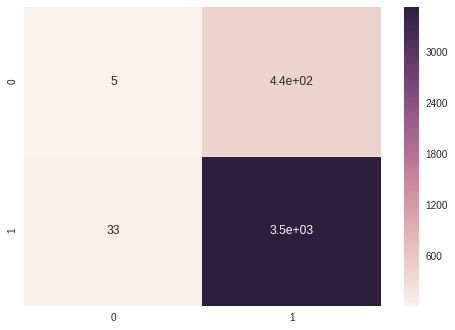

In [0]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### Linear SVM

### Bag of Words and Standardization

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
bow_train = cv.fit_transform(x_train_1L)
print("Shape of BOW vector:- ",bow_train.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
bow_train_st = sc.fit_transform(bow_train)

Shape of BOW vector:-  (80000, 34646)


### Parameter tuning of Linear SVM(SGDClassifier)

In [38]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss='hinge',class_weight='balanced')
param_grid = {'alpha':np.random.uniform(10**-4,10**3,100)}
rs = RandomizedSearchCV(classifier,param_grid,cv = 10,scoring = 'roc_auc',n_jobs=-1)
rs.fit(bow_train_st,y_train_1L)
print("Best parameter:- ",rs.best_params_)
print("Best score:- ",rs.best_score_)

Best parameter:-  {'alpha': 334.4172155571544}
Best score:-  0.44361491569925054
CPU times: user 1.05 s, sys: 127 ms, total: 1.18 s
Wall time: 19.5 s


### Training and testing the Linear SVM classifier

In [43]:
%%time
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss = 'hinge',class_weight='balanced',alpha=334.41)
classifier.fit(bow_train_st,y_train_1L)
bow_test = cv.transform(x_test_1L)
bow_test_st = sc.transform(bow_test)   # Standardizing the test data
y_pred = classifier.predict(bow_test_st)
print("BOW test accuracy:- ",accuracy_score(y_test_1L,y_pred))
print("Roc Auc score:- ",roc_auc_score(y_test_1L,y_pred))
print("F1 score:- ",f1_score(y_test_1L,y_pred))
print("Training accuracy:- ",accuracy_score(y_train_1L,classifier.predict(bow_train_st)))

BOW test accuracy:-  0.7481
Roc Auc score:-  0.49866138015670725
F1 score:-  0.8523273537343181
Training accuracy:-  0.8422
CPU times: user 857 ms, sys: 2.66 ms, total: 860 ms
Wall time: 864 ms


### Important Features

In [41]:
imp_features(cv,classifier)

Shape of Positive dataframe:- , (25490, 2)
Shape of Negative dataframe:-  (9156, 2)
Top ten positive predictors:- 
      Words      Coef
0      sip  0.000047
1    minim  0.000046
2  finicki  0.000044
3       oz  0.000044
4  contain  0.000043
5  italian  0.000043
6   pantri  0.000042
7     bang  0.000042
8   smooth  0.000041
9  conveni  0.000041

Top ten negative predictors:- 
       Words      Coef
0       dis  0.000099
1   kristin  0.000076
2    wicker  0.000076
3     melba  0.000073
4  cracklin  0.000069
5   detoxif  0.000067
6  carnauba  0.000067
7      peed  0.000067
8    tendon  0.000066
9    woulda  0.000063


### Confusion Matrix

Confusion Matrix:- 
 [[  449  2226]
 [ 2930 14395]]


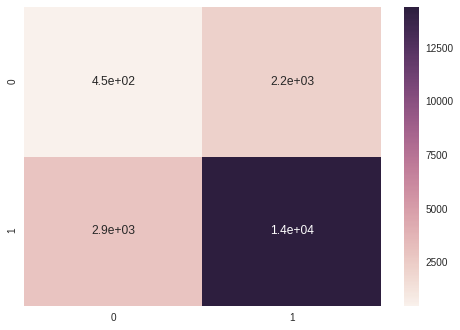

In [40]:
cm = confusion_matrix(y_test_1L,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### ============================================================================================================

## Tfidf Implementation

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10,max_features=500,sublinear_tf=True)
tfidf_train = tfidf.fit_transform(x_train)
print("Shape of tfidf_train:- ",tfidf_train.shape)

Shape of tfidf_train:-  (16000, 500)


### Standardizing the data

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
tfidf_train_st = sc.fit_transform(tfidf_train)

### SVM with RBF Kernel

### Parameter tuning using GridSearchCV

In [0]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
classifier = SVC(kernel='rbf',cache_size=1000,class_weight='balanced')
param_grid = {"C":[0.1,1,10,100],'gamma':[0.001,0.01,1]}
gs = GridSearchCV(classifier,param_grid,cv = 5,scoring = 'roc_auc',n_jobs = -1)
gs.fit(tfidf_train_st,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best parameter:-  {'C': 1, 'gamma': 1}
Best score:-  0.49840245277351486
CPU times: user 1min 1s, sys: 707 ms, total: 1min 2s
Wall time: 1h 1min 18s


### Testing the model on test with tuned hyperparameter.

In [0]:
%%time
tfidf_test = tfidf.transform(x_test)
tfidf_test = sc.transform(tfidf_test)   # Standardizing the test data
classifier = SVC(C=1,gamma=1,kernel='rbf',cache_size=1000,class_weight='balanced')
classifier.fit(tfidf_train_st,y_train)
y_pred = classifier.predict(tfidf_test)
print("Tfdif test accuracy:- ",accuracy_score(y_test,y_pred))
print("F1 score:- ",f1_score(y_test,y_pred))
print("Training accuracy:- ",accuracy_score(y_train,classifier.predict(tfidf_train_st)))

Tfdif test accuracy:-  0.89
F1 score:-  0.9417835406192114
Training accuracy:-  0.9991875
CPU times: user 2min 17s, sys: 161 ms, total: 2min 17s
Wall time: 2min 17s


### Confusion Matrix

Confusion Matrix:- 
 [[   1  440]
 [   0 3559]]


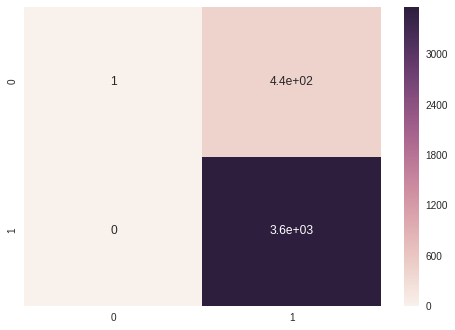

In [0]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### Linear SVM

### Tfidf vectorizer and Standardization

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True)
tfidf_train = tfidf.fit_transform(x_train_1L)
print("Shape of tfidf_train:- ",tfidf_train.shape)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
tfidf_train_st = sc.fit_transform(tfidf_train)

Shape of tfidf_train:-  (80000, 34646)


### Parameter Tuning using RandomizedSearchCV

In [54]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss='hinge',class_weight='balanced')
param_grid = {'alpha':np.random.uniform(10**-4,10**3,100)}
rs = RandomizedSearchCV(classifier,param_grid,cv = 5,scoring = 'roc_auc',n_jobs=-1)
rs.fit(tfidf_train_st,y_train_1L)
print("Best parameter:- ",rs.best_params_)
print("Best score:- ",rs.best_score_)

Best parameter:-  {'alpha': 291.8015631286678}
Best score:-  0.472049941445681
CPU times: user 630 ms, sys: 57.9 ms, total: 688 ms
Wall time: 9.27 s


### Training and testing the linear SVM classifier

In [56]:
%%time
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss='hinge',class_weight='balanced',alpha=291.8)
classifier.fit(tfidf_train_st,y_train_1L)
tfidf_test = tfidf.transform(x_test_1L)
tfidf_test_st = sc.transform(tfidf_test)   # Standardizing the test data
y_pred = classifier.predict(tfidf_test_st)
print("Tfidf test accuracy:- ",accuracy_score(y_test_1L,y_pred))
print("F1 score:- ",f1_score(y_test_1L,y_pred))
print("Training accuracy:- ",accuracy_score(y_train_1L,classifier.predict(tfidf_train_st)))

Tfidf test accuracy:-  0.68285
F1 score:-  0.8042827609614613
Training accuracy:-  0.806475
CPU times: user 921 ms, sys: 6.4 ms, total: 927 ms
Wall time: 928 ms


### Important Features

In [58]:
imp_features(tfidf,classifier)

Shape of Positive dataframe:- , (25612, 2)
Shape of Negative dataframe:-  (9034, 2)
Top ten positive predictors:- 
      Words      Coef
0   sticki  0.000063
1  contain  0.000057
2  collect  0.000056
3  italian  0.000053
4    curri  0.000052
5   pantri  0.000052
6    minim  0.000052
7      pod  0.000050
8       oz  0.000050
9      sip  0.000050

Top ten negative predictors:- 
        Words      Coef
0        dis  0.000110
1      melba  0.000093
2   cracklin  0.000092
3    kristin  0.000085
4       arar  0.000085
5  fettucini  0.000082
6   crawfish  0.000077
7       maki  0.000077
8     truley  0.000076
9     wicker  0.000076


### Confusion Matrix

Confusion Matrix:- 
 [[  624  2051]
 [ 4292 13033]]


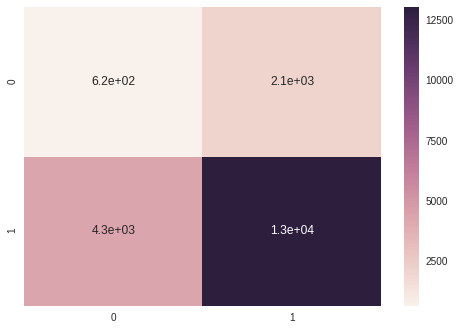

In [57]:
cm = confusion_matrix(y_test_1L,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### ===========================================================================================

## Word2Vec

In [0]:
#Function to create list of sentences
def sent_list(x):
    list_of_sent = []
    for sent in tqdm(x):
        words = []
        for w in sent.split():
            words.append(w)
        list_of_sent.append(words)
    return list_of_sent

In [0]:
#implementing word2vec
from gensim.models import Word2Vec
sent_train = sent_list(x_train)
w2v = Word2Vec(sent_train,size=50,min_count=2,workers=4)

100%|██████████| 16000/16000 [00:00<00:00, 92735.22it/s]


### Average Word2Vec Implementation

In [0]:
#Function to create avg word2vec vector
def avgw2v(x):
    avgw2v_vec = []
    for sent in tqdm(x):
        sent_vec = np.zeros(50)
        count = 0
        for word in sent:
            try:
                vec = w2v.wv[word]
                sent_vec+=vec
                count+=1
            except:
                pass
        sent_vec/=count
        avgw2v_vec.append(sent_vec)
    return avgw2v_vec

In [0]:
#Creating average word2vec training data
avgw2v_train = np.array(avgw2v(sent_train))
print("Shape of avg word2vec train data:- ",avgw2v_train.shape)

100%|██████████| 16000/16000 [00:02<00:00, 7013.25it/s]

Shape of avg word2vec train data:-  (16000, 50)


### Standardizing the data

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
avgw2v_train_st = sc.fit_transform(avgw2v_train)

### SVM with RBF kernel

### Parameter tuning using GridSearchCV

In [0]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
classifier = SVC(kernel='rbf',cache_size=1000,class_weight='balanced')
param_grid = {"C":[0.1,1,10,100],'gamma':[0.001,0.01,1,10]}
gs = GridSearchCV(classifier,param_grid,cv = 5,scoring = 'roc_auc',n_jobs = -1)
gs.fit(avgw2v_train_st,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best parameter:-  {'C': 100, 'gamma': 0.01}
Best score:-  0.5029708457499885
CPU times: user 48.8 s, sys: 855 ms, total: 49.7 s
Wall time: 34min 44s


### Testing the model on test data with tuned parameter

In [0]:
%%time
sent_test = sent_list(x_test)
avgw2v_test = np.array(avgw2v(sent_test))
avgw2v_test_st = sc.transform(avgw2v_test)   # Standardizing the test data
classifier = SVC(C=100,gamma=0.01,kernel='rbf',cache_size=1000,class_weight='balanced')
classifier.fit(avgw2v_train_st,y_train)
y_pred = classifier.predict(avgw2v_test_st)
print("AvgWord2Vec test accuracy:- ",accuracy_score(y_test,y_pred))
print("F1 score:- ",f1_score(y_test,y_pred))
print("Training accuracy:- ",accuracy_score(y_train,classifier.predict(avgw2v_train_st)))

100%|██████████| 4000/4000 [00:00<00:00, 6533.91it/s]


AvgWord2Vec test accuracy:-  0.6655
F1 score:-  0.7912636505460219
Training accuracy:-  0.83
CPU times: user 1min 8s, sys: 127 ms, total: 1min 9s
Wall time: 1min 9s


### Confusion Matrix

Confusion Matrix:- 
 [[ 126  315]
 [1023 2536]]


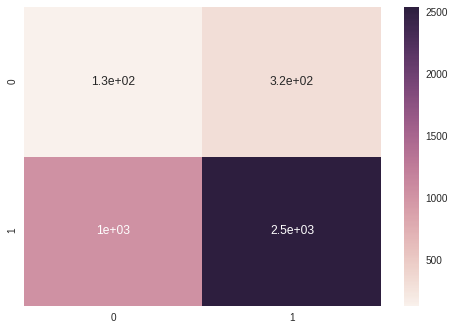

In [0]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### Linear SVM

### Average Word2Vec and Standardization

In [62]:
#implementing word2vec
from gensim.models import Word2Vec
sent_train = sent_list(x_train_1L)
w2v = Word2Vec(sent_train,size=50,min_count=2,workers=4)

#Creating average word2vec training data
avgw2v_train = np.array(avgw2v(sent_train))
print("Shape of avg word2vec train data:- ",avgw2v_train.shape)

#Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
avgw2v_train_st = sc.fit_transform(avgw2v_train)

100%|██████████| 80000/80000 [00:12<00:00, 6509.64it/s]


Shape of avg word2vec train data:-  (80000, 50)


### Parameter Tuning using RandomizedSearchCV

In [89]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss='hinge',class_weight='balanced')
param_grid = {'alpha':np.random.uniform(10**-4,10**3,100)}
rs = RandomizedSearchCV(classifier,param_grid,cv = 5,scoring = 'roc_auc',n_jobs=-1)
rs.fit(avgw2v_train_st,y_train_1L)
print("Best parameter:- ",rs.best_params_)
print("Best score:- ",rs.best_score_)

Best parameter:-  {'alpha': 2.8050007553176686}
Best score:-  0.49878668146831423
CPU times: user 538 ms, sys: 56.1 ms, total: 594 ms
Wall time: 9.07 s


### Training and testing the linear SVM classifier

In [85]:
%%time
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss = 'hinge',class_weight='balanced',alpha=0.90)
classifier.fit(avgw2v_train_st,y_train_1L)
sent_test = sent_list(x_test_1L)
avgw2v_test = np.array(avgw2v(sent_test))
avgw2v_test_st = sc.transform(avgw2v_test)   # Standardizing the test data
y_pred = classifier.predict(avgw2v_test_st)
print("\nAverage word2vec test accuracy:- ",accuracy_score(y_test_1L,y_pred))
print("F1 score:- ",f1_score(y_test_1L,y_pred))
print("Training accuracy:- ",accuracy_score(y_train_1L,classifier.predict(avgw2v_train_st)))

100%|██████████| 20000/20000 [00:03<00:00, 6605.04it/s]



Average word2vec test accuracy:-  0.7493
F1 score:-  0.8532888576779025
Training accuracy:-  0.75975
CPU times: user 3.42 s, sys: 57.1 ms, total: 3.48 s
Wall time: 3.47 s


### Confusion Matrix

Confusion Matrix:- 
 [[  405  2270]
 [ 2744 14581]]


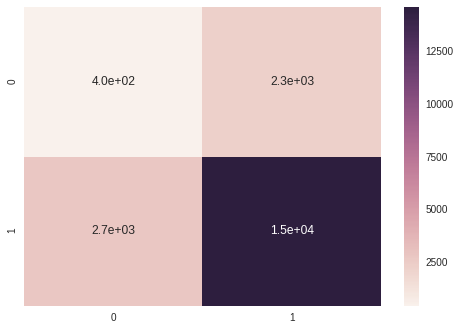

In [86]:
cm = confusion_matrix(y_test_1L,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### ==================================================================================================

### Tfidf Word2Vec implementation

In [0]:
#Function for creating tfidf weighted Word2Vec
def tfidfw2v(x):
    dictionary = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))
    tfidf_w2v_vec = []
    i=0
    for sent in tqdm(x):
        sent_vec = np.zeros(50)
        weights = 0
        for word in sent:
            try:
                vec = w2v.wv[word]
                tfidf_value = dictionary[word]*sent.count(word)
                sent_vec+=(tfidf_value*vec)
                weights+=tfidf_value
            except:
                pass
        sent_vec/=weights
        tfidf_w2v_vec.append(sent_vec)
        i+=1
    return tfidf_w2v_vec

In [0]:
tfidfw2v_train = np.array(tfidfw2v(sent_train))
print("Shape of tfidf avgw2v train vector:- ",tfidfw2v_train.shape)

100%|██████████| 16000/16000 [00:05<00:00, 3082.80it/s]

Shape of tfidf avgw2v train vector:-  (16000, 50)


### Standardizing the data

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
tfidfw2v_train_st = sc.fit_transform(tfidfw2v_train)

### SVM with RBF kernel

### Parameter tuning using GridSearchCV

In [0]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
classifier = SVC(kernel='rbf',cache_size=1000,class_weight='balanced')
param_grid = {"C":[0.1,1,10,100],'gamma':[0.001,0.01,1]}
gs = GridSearchCV(classifier,param_grid,cv = 5,scoring = 'roc_auc',n_jobs = -1)
gs.fit(tfidfw2v_train_st,y_train)
print("Best parameter:- ",gs.best_params_)
print("Best score:- ",gs.best_score_)

Best parameter:-  {'C': 1, 'gamma': 0.001}
Best score:-  0.4978167030342269
CPU times: user 32.1 s, sys: 501 ms, total: 32.6 s
Wall time: 26min 14s


### Testing the model on test data with tuned parameter.

In [0]:
%%time
sent_test = sent_list(x_test)
tfidfw2v_test = np.array(tfidfw2v(sent_test))
tfidfw2v_test_st = sc.transform(tfidfw2v_test)   # Standardizing the test data
classifier = SVC(C=1,gamma=0.001,kernel='rbf',cache_size=1000,class_weight='balanced')
classifier.fit(tfidfw2v_train_st,y_train)
y_pred = classifier.predict(tfidfw2v_test_st)
print("TfidfWord2Vec test accuracy:- ",accuracy_score(y_test,y_pred))
print("F1 score:- ",f1_score(y_test,y_pred))
print("Training accuracy:- ",accuracy_score(y_train,classifier.predict(tfidfw2v_train_st)))

100%|██████████| 4000/4000 [00:01<00:00, 2870.70it/s]


TfidfWord2Vec test accuracy:-  0.5275
F1 score:-  0.6686535764375877
Training accuracy:-  0.5666875
CPU times: user 1min 5s, sys: 180 ms, total: 1min 5s
Wall time: 1min 5s


### Confusion Matrix

Confusion Matrix:- 
 [[ 203  238]
 [1652 1907]]


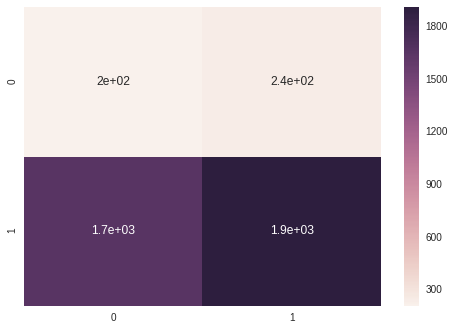

In [0]:
cm = confusion_matrix(y_test,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

### Linear SVM

### TFidf Word2Vec and Standardization

In [91]:
#implementing word2vec
from gensim.models import Word2Vec
sent_train = sent_list(x_train_1L)
w2v = Word2Vec(sent_train,size=50,min_count=2,workers=4)

#Creating average word2vec training data
tfidfw2v_train = np.array(tfidfw2v(sent_train))
print("Shape of avg word2vec train data:- ",tfidfw2v_train.shape)

#Standardizing the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
tfidfw2v_train_st = sc.fit_transform(tfidfw2v_train)

100%|██████████| 80000/80000 [00:31<00:00, 2530.58it/s]


Shape of avg word2vec train data:-  (80000, 50)


### Parameter tuning using RandomizedSearchCV

In [95]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss='hinge',class_weight='balanced')
param_grid = {'alpha':np.random.uniform(10**-4,10**3,100)}
rs = RandomizedSearchCV(classifier,param_grid,cv = 5,scoring = 'roc_auc',n_jobs=-1)
rs.fit(tfidfw2v_train_st,y_train_1L)
print("Best parameter:- ",rs.best_params_)
print("Best score:- ",rs.best_score_)

Best parameter:-  {'alpha': 42.866008540189036}
Best score:-  0.49107703460109003
CPU times: user 537 ms, sys: 49.8 ms, total: 587 ms
Wall time: 9.28 s


### Training and testing the linear SVM classifier

In [107]:
%%time
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss = 'hinge',class_weight='balanced',alpha=0.5)
classifier.fit(tfidfw2v_train_st,y_train_1L)
sent_test = sent_list(x_test_1L)
tfidfw2v_test = np.array(tfidfw2v(sent_test))
tfidfw2v_test_st = sc.transform(tfidfw2v_test)   # Standardizing the test data
y_pred = classifier.predict(tfidfw2v_test_st)
print("\nTfidf word2vec test accuracy:- ",accuracy_score(y_test_1L,y_pred))
print("F1 score:- ",f1_score(y_test_1L,y_pred))
print("Training accuracy:- ",accuracy_score(y_train_1L,classifier.predict(tfidfw2v_train_st)))

100%|██████████| 20000/20000 [00:07<00:00, 2789.96it/s]


Tfidf word2vec test accuracy:-  0.85275
F1 score:-  0.9203386621223186
Training accuracy:-  0.86585
CPU times: user 7.68 s, sys: 467 ms, total: 8.15 s
Wall time: 7.62 s


### Confusion Matrix

Confusion Matrix:- 
 [[   43  2632]
 [  313 17012]]


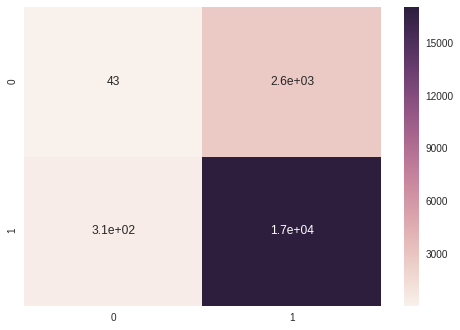

In [108]:
cm = confusion_matrix(y_test_1L,y_pred)
print("Confusion Matrix:- \n",cm)
sns.heatmap(cm,annot = True)

## Results of RBF Kernel:-

| Model | Hyperparameter(C,gamma) | Train Accuracy | Test Accuracy |
| - | - | - | - |
| Bag of Words | C=100, gamma=0.01 | 99.9 | 88.2 |
|Tfidf | C=1, gamma=1 | 99.9 | 89 |
| Avg Word2Vec | C=100, gamma=0.01 | 83 | 66.5 |
| Tfidf Word2Vec | C=1, gamma=0.001 | 56.6 | 52.7 |

## Results of Linear Kernel:-

| Model | Hyperparameter(alpha) | Train Accuracy | Test Accuracy |
| - | - | - | - |
| Bag of Words |  334.4 | 84 | 74.8 |
|Tfidf | 291.8 | 80 | 68.2 |
| Avg Word2Vec | 0.9 | 75.9 | 74.9 |
| Tfidf Word2Vec | 0.5 | 86.5 | 85.2 |